In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

In [33]:
 dataset_path = "C:/Users/Sadiya Sajid/Downloads/waste_classification/garbage_classification"

In [34]:
image_size=(128,128)
batch_size=8

In [35]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(128,128),
    batch_size=8

)

Found 15515 files belonging to 12 classes.


In [5]:
class_names=dataset.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

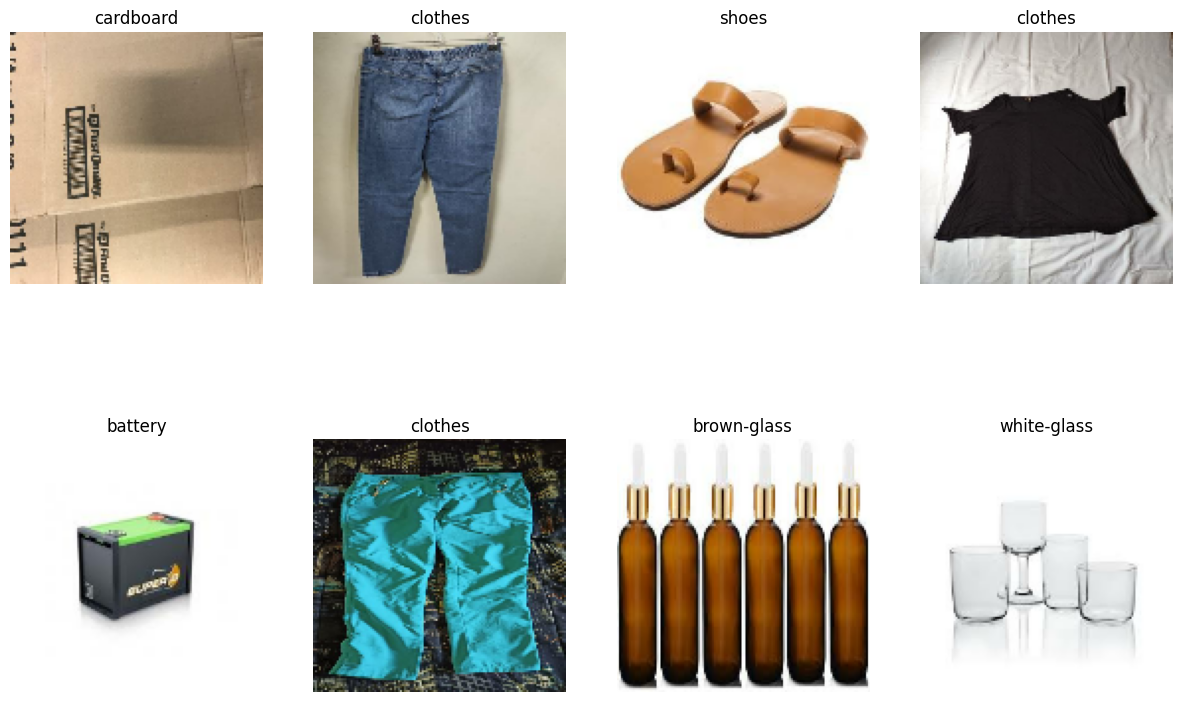

In [6]:
fig = plt.figure(figsize=(15, 15))

for image_batch, label_batch in dataset.take(1):
    batch_size = image_batch.shape[0]  
    for i in range(min(12, batch_size)):   
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

plt.show()

In [7]:
# 80% training, 10% validate, 10% testing
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=15)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [12]:
input_shape=(8,128,128,3)
n_classes=12

model=tf.keras.Sequential([
    resize_and_rescale,
    data_augumentation,
    
    layers.Conv2D(64,(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 224, 224, 3)          0         
                                                                 
 sequential_1 (Sequential)   (8, 224, 224, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 222, 222, 64)         1792      
                                                                 
 max_pooling2d (MaxPooling2  (8, 111, 111, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (8, 109, 109, 64)         36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (8, 54, 54, 64)           0         
 g2D)                                                 

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [15]:
history=model.fit(
    train_ds,
    epochs=50,
    batch_size=8,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


1552/1552 [==============================] - 309s 195ms/step - loss: 1.5980 - accuracy: 0.4603 - val_loss: 1.3719 - val_accuracy: 0.4910
Epoch 2/50
1552/1552 [==============================] - 315s 203ms/step - loss: 1.2972 - accuracy: 0.5550 - val_loss: 1.1620 - val_accuracy: 0.6095
Epoch 3/50
1552/1552 [==============================] - 304s 196ms/step - loss: 1.1965 - accuracy: 0.5928 - val_loss: 1.1225 - val_accuracy: 0.6321
Epoch 4/50
1552/1552 [==============================] - 299s 192ms/step - loss: 1.1472 - accuracy: 0.6157 - val_loss: 1.0670 - val_accuracy: 0.6437
Epoch 5/50
1552/1552 [==============================] - 298s 192ms/step - loss: 1.0793 - accuracy: 0.6372 - val_loss: 0.9957 - val_accuracy: 0.6772
Epoch 6/50
1552/1552 [==============================] - 298s 192ms/step - loss: 1.0468 - accuracy: 0.6453 - val_loss: 0.9709 - val_accuracy: 0.6772
Epoch 7/50
1552/1552 [==============================] - 301s 194ms/step - loss: 1.0019 - accuracy: 0.6632 - va

In [19]:
scores=model.evaluate(test_ds)

194/194 [==============================] - 18s 93ms/step - loss: 0.6296 - accuracy: 0.7841


In [25]:
acc=history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss=history.history["loss"]
val_loss= history.history["val_loss"]

epochs=70

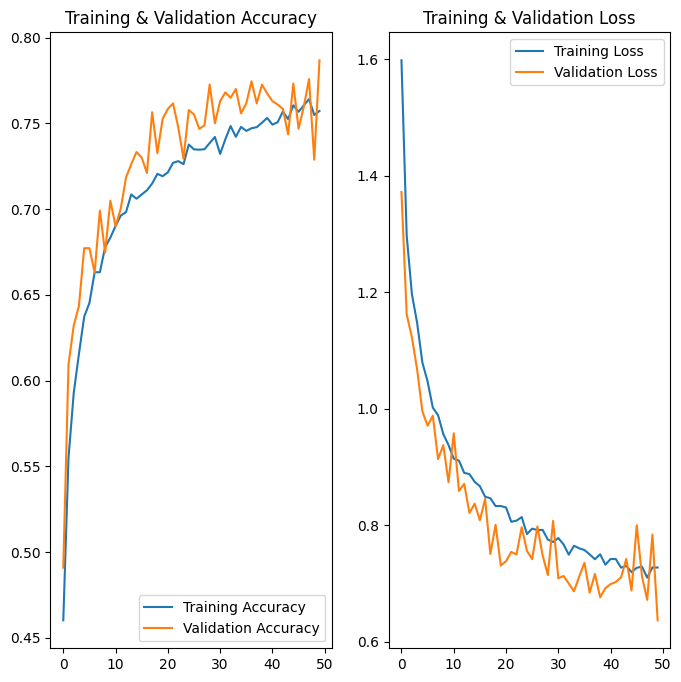

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label="Training Accuracy")
plt.plot(range(50),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training & Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(50),loss,label="Training Loss")
plt.plot(range(50),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training & Validation Loss")
plt.show()

Image to prediction
Actual Label paper
1/1 [==============================] - 0s 456ms/step
Predicted Label paper


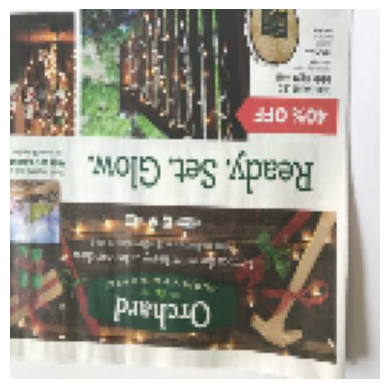

In [28]:
import numpy as np
for image_batch , label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("Image to prediction")
    plt.imshow(first_image)
    print("Actual Label",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

